# 2D ring resonator

View this project in [Tidy3D Web App](https://tidy3d.simulation.cloud/workbench?taskId=4b6c5361-8274-4a9b-8d4d-e0c51f31ef6f).

This is a simple example of using Tidy3D to perform a 2D simulation of a ring resonator side coupled to a dielectric waveguide.

<img src="img/ring.png" alt="diagram" width="300"/>

With a center wavelength of 500 nm and 10 nm resolution, this is a challenging FDTD problem because of the large simulation size and the large number of time steps needed to capture the resonance of the ring. However, it can be easily handled with Tidy3D.

For more integrated photonic examples such as the [8-Channel mode and polarization de-multiplexer](https://www.flexcompute.com/tidy3d/examples/notebooks/8ChannelDemultiplexer/), the [broadband bi-level taper polarization rotator-splitter](https://www.flexcompute.com/tidy3d/examples/notebooks/BilevelPSR/), and the [broadband directional coupler](https://www.flexcompute.com/tidy3d/examples/notebooks/BroadbandDirectionalCoupler/), please visit our [examples page](https://www.flexcompute.com/tidy3d/examples/). If you are interested in ring resonator simulation in 3D, please check out the [THz filter](https://www.flexcompute.com/tidy3d/examples/notebooks/THzDemultiplexerFilter/) case study.

If you are new to the finite-difference time-domain (FDTD) method, we highly recommend going through our [FDTD101](https://www.flexcompute.com/fdtd101/) tutorials. FDTD simulations can diverge due to various reasons. If you run into any simulation divergence issues, please follow the steps outlined in our [troubleshooting guide](https://www.flexcompute.com/tidy3d/examples/notebooks/DivergedFDTDSimulation/) to resolve it.

In [1]:
# standard python imports
import numpy as np
from numpy import random
import matplotlib.pyplot as plt

# tidy3D import
import tidy3d.web as web
import tidy3d as td


## Initial setup

Our ring resonator will include a ring centered at (0,0) with a waveguide just above the ring spanning the x direction.

<img src="img/ring_resonator_schematic.png" alt="schematic" width="300"/>

In [2]:
# define geometry
wg_width = 0.25
couple_width = 0.13
ring_radius = 2.5
ring_wg_width = 0.25
wg_spacing = 0.5
buffer = 1.0

# compute quantities based on geometry parameters
x_span = 2 * wg_spacing + 2 * ring_radius + 2 * buffer
y_span = 2 * ring_radius + ring_wg_width + wg_width + couple_width + 2 * buffer
sim_center_y = (couple_width + wg_width) / 2
wg_insert_x = ring_radius + wg_spacing
wg_center_y = ring_radius + ring_wg_width / 2.0 + couple_width + wg_width / 2.0


Define frequency parameters for sources and monitors based on the wavelength range of interest. Since in this case study we are investigating the system's response over a wide range of frequencies we will use a broadband mode source that takes into account frequency-dependent character of waveguide modes. The Tidy3D's broadband feature is designed in such a way that it produces the most accurate results in the range `(freq0 - 1.5 * fwidth, freq0 + 1.5 * fwidth)`, thus we define parameters `freq0` and `fwidth` such that the frequency range of interest is exactly covered by `(freq0 - 1.5 * fwidth, freq0 + 1.5 * fwidth)`.

In [3]:
# wavelength range of interest
lambda_beg = 0.5
lambda_end = 0.6

# define pulse parameters
freq_beg = td.C_0 / lambda_end
freq_end = td.C_0 / lambda_beg
freq0 = (freq_beg + freq_end) / 2
fwidth = (freq_end - freq0) / 1.5

min_steps_per_wvl = 30
run_time = 15e-12


Define [materials](../api/_autosummary/tidy3d.Medium.html).

In [4]:
n_bg = 1.0
n_solid = 1.5
background = td.Medium(permittivity=n_bg**2)
solid = td.Medium(permittivity=n_solid**2)


Define [structures](../api/_autosummary/tidy3d.Structure.html).


In [5]:
# waveguide
waveguide = td.Structure(
    geometry=td.Box(
        center=[0, wg_center_y, 0],
        size=[td.inf, wg_width, td.inf],
    ),
    medium=solid,
    name="waveguide",
)

# outer ring boundary
outer = td.Cylinder(
    center=[0, 0, 0],
    axis=2,
    radius=ring_radius + ring_wg_width / 2.0,
    length=td.inf,
)

# inner ring boundary
inner = td.Cylinder(
    center=[0, 0, 0],
    axis=2,
    radius=ring_radius - ring_wg_width / 2.0,
    length=td.inf,
)

ring = td.Structure(
    geometry=outer - inner,
    medium=solid,
    name="outer_ring",
)


Compute and visualize the waveguide modes.

In [6]:
from tidy3d.plugins.mode import ModeSolver
from tidy3d.plugins.mode.web import run as run_ms

mode_plane = td.Box(
    center=[-wg_insert_x, wg_center_y, 0],
    size=[0, 2, td.inf],
)

sim_modesolver = td.Simulation(
    center=[0, sim_center_y, 0],
    size=[x_span, y_span, 0],
    grid_spec=td.GridSpec.auto(
        min_steps_per_wvl=min_steps_per_wvl, wavelength=td.C_0 / freq0
    ),
    structures=[waveguide],
    run_time=1e-12,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.Periodic()),
    medium=background,
)

mode_spec = td.ModeSpec(num_modes=2)
mode_solver = ModeSolver(
    simulation=sim_modesolver, plane=mode_plane, mode_spec=mode_spec, freqs=[freq0]
)
mode_data = run_ms(mode_solver)


00:23:41 PST Mode solver created with                                           
             task_id='fdve-328a8007-7c76-43bc-9e22-0e209af2484e',               
             solver_id='mo-12f0a0a7-d919-4c85-95ff-283e79958244'.

Output()

Output()

00:23:43 PST Mode solver status: queued

00:23:54 PST Mode solver status: running

00:24:03 PST Mode solver status: success

Output()

Tidy3D is warning us that the simulation does not contain a source. However, since this simulation is used to construct the mode solver and will not be run directly, we can ignore this warning.

wavelength     n eff  k eff  TE (Ey) fraction  \
f            mode_index                                                  
5.496195e+14 0             0.545455  1.348767    0.0      2.867437e-13   
             1             0.545455  1.271590    0.0      1.000000e+00   

                         wg TE fraction  wg TM fraction  mode area  
f            mode_index                                             
5.496195e+14 0                 1.000000        0.882227   0.309920  
             1                 0.789246        1.000000   0.454015

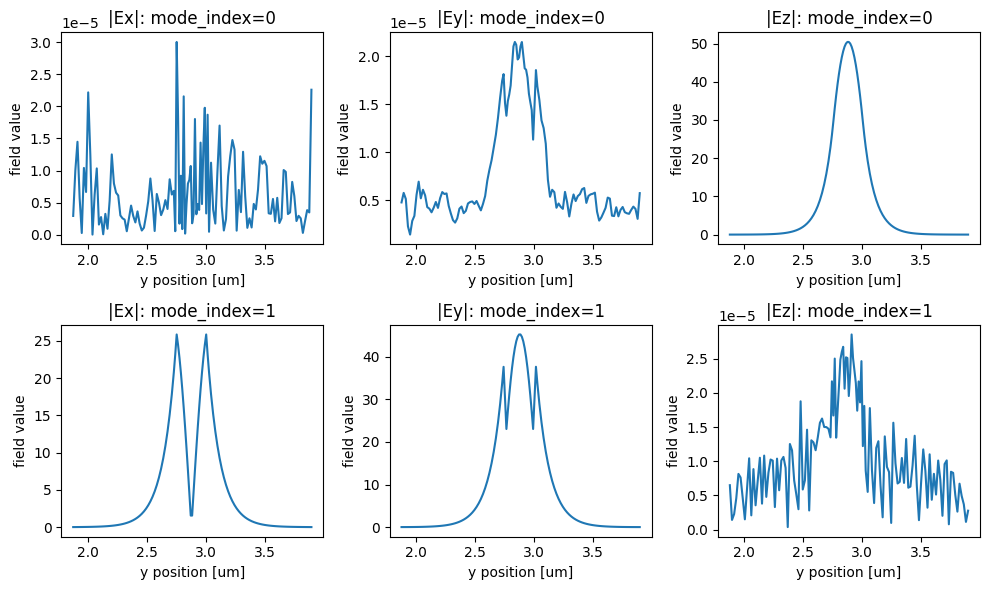

In [7]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(
    2, 3, tight_layout=True, figsize=(10, 6)
)
mode_data.Ex.sel(mode_index=0, f=freq0).abs.plot(ax=ax1)
mode_data.Ey.sel(mode_index=0, f=freq0).abs.plot(ax=ax2)
mode_data.Ez.sel(mode_index=0, f=freq0).abs.plot(ax=ax3)
mode_data.Ex.sel(mode_index=1, f=freq0).abs.plot(ax=ax4)
mode_data.Ey.sel(mode_index=1, f=freq0).abs.plot(ax=ax5)
mode_data.Ez.sel(mode_index=1, f=freq0).abs.plot(ax=ax6)
ax1.set_title("|Ex|: mode_index=0")
ax2.set_title("|Ey|: mode_index=0")
ax3.set_title("|Ez|: mode_index=0")
ax4.set_title("|Ex|: mode_index=1")
ax5.set_title("|Ey|: mode_index=1")
ax6.set_title("|Ez|: mode_index=1")

mode_data.to_dataframe()


From the above plots, we see that 

`mode_index=0` corresponds to exciting 0-th order TM mode (E=Ez) and 

`mode_index=1` corresponds to exciting 0-th order TE mode (E=Ey).

We can therefore switch the mode index accordingly based on our polarization.

Let's select Ey and create the source for it. As mentioned before, we will use a broadband mode source that will approximate the chosen mode's frequency dependence in the range `(freq0 - 1.5 * fwidth, freq0 + 1.5 * fwidth)` using 11 Chebyshev polynomials.

In [8]:
mode_source = td.ModeSource(
    size=mode_plane.size,
    center=mode_plane.center,
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    mode_spec=td.ModeSpec(num_modes=2),
    mode_index=1,
    direction="+",
    num_freqs=11,  # using 11 (Chebyshev) points to approximate frequency dependence
)


In addition, let's monitor both the fields in plane as well as the output mode amplitudes into the fundamental TE mode.

In [9]:
# monitor steady state fields at central frequency over whole domain
field_monitor = td.FieldMonitor(
    center=[0, 0, 0], size=[td.inf, td.inf, 0], freqs=[freq0], name="field"
)


# monitor the mode amps on the output waveguide
lambdas_measure = np.linspace(lambda_beg, lambda_end, 1001)
freqs_measure = td.C_0 / lambdas_measure[::-1]

mode_monitor = td.ModeMonitor(
    size=mode_plane.size,
    center=mode_plane.center,
    freqs=freqs_measure,
    mode_spec=td.ModeSpec(num_modes=2),
    name="mode",
)

# lets reset the center to the on the right hand side of the simulation though
mode_monitor = mode_monitor.copy(update=dict(center=[wg_insert_x, wg_center_y, 0]))


Define [simulation](../api/_autosummary/tidy3d.Simulation.html).
To make the simulation 2D, we can just set the simulation size in one of the dimensions to be 0. However, note that we still have to define a grid size in that direction. Additionally, we lower the shutoff factor to make sure the high-frequency response of this resonant system is accurately resolved.

In [10]:
# create simulation
sim = td.Simulation(
    center=[0, sim_center_y, 0],
    size=[x_span, y_span, 0],
    grid_spec=td.GridSpec.auto(
        min_steps_per_wvl=min_steps_per_wvl, wavelength=td.C_0 / freq0
    ),
    structures=[waveguide, ring],
    sources=[mode_source],
    monitors=[field_monitor, mode_monitor],
    run_time=run_time,
    boundary_spec=td.BoundarySpec(
        x=td.Boundary.pml(), y=td.Boundary.pml(), z=td.Boundary.periodic()
    ),
    medium=background,
    shutoff=1e-9,
)


Visualize structure, source, and modes.

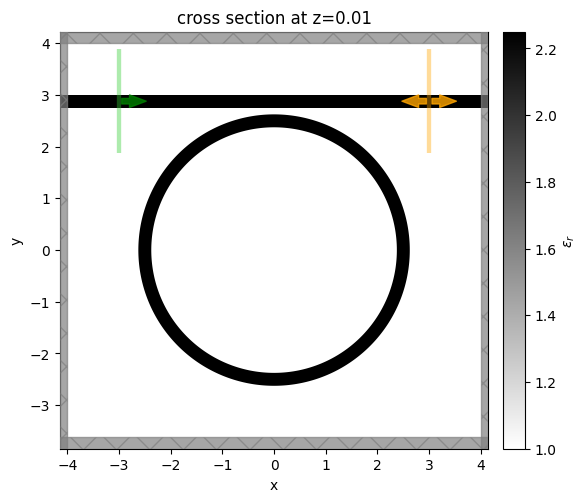

In [11]:
# plot the two simulations
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sim.plot_eps(z=0.01, ax=ax)
plt.show()


## Run Simulation
Run simulations on our server. 

In [12]:
# use function above to run simulation
sim_data = web.run(
    sim, task_name="ring_resonator", path="data/simulation_data.hdf5", verbose=True
)


00:24:05 PST Created task 'ring_resonator' with task_id                         
             'fdve-d19ab1b0-0dee-4c56-bc79-87b51467487d' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=574622;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d19ab1b0-0dee-4c56-bc79-87b51467487d\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=872175;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d19ab1b0-0dee-4c56-bc79-87b51467487d\taskId]8;;\]8;id=574622;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d19ab1b0-0dee-4c56-bc79-87b51467487d\=]8;;\]8;id=314526;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d19ab1b0-0dee-4c56-bc79-87b51467487d\fdve]8;;\]8;id=574622;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d19ab1b0-0dee-4c56-bc79-87b51467487d\-d19ab1b0-0de]8;;\
             ]8;id=574622;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d19ab1b0-0dee-4c56-bc79-87b51467487d\e-4c56-bc79-87b51467487d']8;;\.

Output()

00:24:06 PST status = queued

Output()

00:24:12 PST status = preprocess

00:24:15 PST Maximum FlexCredit cost: 0.187. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

00:26:34 PST early shutoff detected at 76%, exiting.

             status = postprocess

Output()

00:26:41 PST status = success

             View simulation result at                                          
             ]8;id=830973;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d19ab1b0-0dee-4c56-bc79-87b51467487d\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=971833;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d19ab1b0-0dee-4c56-bc79-87b51467487d\taskId]8;;\]8;id=830973;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d19ab1b0-0dee-4c56-bc79-87b51467487d\=]8;;\]8;id=156743;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d19ab1b0-0dee-4c56-bc79-87b51467487d\fdve]8;;\]8;id=830973;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d19ab1b0-0dee-4c56-bc79-87b51467487d\-d19ab1b0-0de]8;;\
             ]8;id=830973;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d19ab1b0-0dee-4c56-bc79-87b51467487d\e-4c56-bc79-87b51467487d']8;;\.

Output()

00:26:43 PST loading simulation from data/simulation_data.hdf5

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

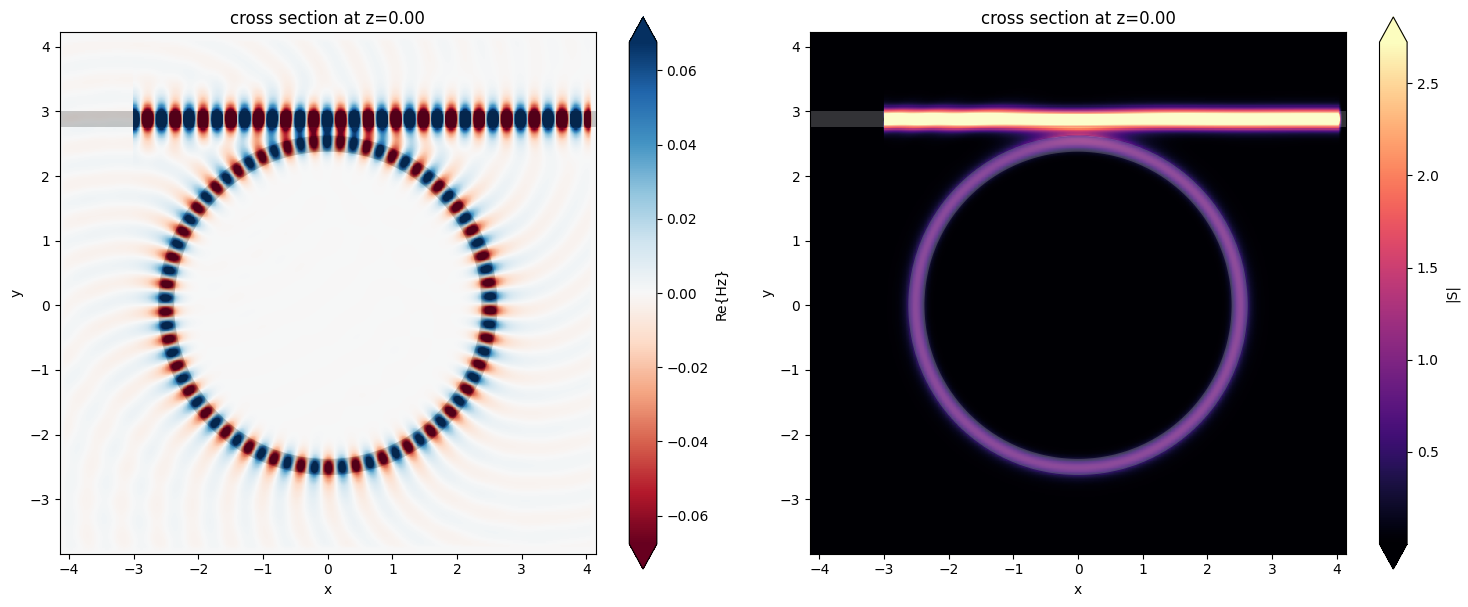

In [13]:
# visualize normalization run
fig, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(15, 6))

ax1 = sim_data.plot_field("field", "Hz", val="real", z=0, ax=ax1)
ax2 = sim_data.plot_field("field", "S", val="abs", z=0, ax=ax2)

plt.show()


## Analyze Spectrum

Now let's analyze the mode amplitudes in the output waveguide.

First, let's grab the data to inspect it.

In [14]:
sim_data["mode"].amps


00:26:48 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

<xarray.ModeAmpsDataArray (direction: 2, f: 1001, mode_index: 2)>
array([[[-2.94317387e-09+2.91445052e-07j,
         -9.71604666e-01+5.12200901e-02j],
        [ 2.17934229e-09+4.20271448e-08j,
         -9.71549229e-01+2.69502423e-02j],
        [-5.07514760e-07-1.84006268e-07j,
         -9.70793586e-01+2.33783536e-03j],
        ...,
        [ 2.55032381e-07-2.55035029e-07j,
         -7.14329362e-01-6.94168904e-01j],
        [-1.43616433e-07-7.17271452e-07j,
         -6.71932117e-01-7.33698854e-01j],
        [ 3.74616439e-07-1.59813905e-07j,
         -6.18688141e-01-7.76789335e-01j]],

       [[-5.47670496e-09-7.54511107e-10j,
          5.71212531e-05+1.37591023e-05j],
        [-1.07697845e-08-4.34026945e-10j,
          5.30543848e-05+1.30590513e-05j],
        [ 7.40813785e-09-8.51795919e-11j,
          7.58872600e-05+3.17304225e-05j],
        ...,
        [-8.00938423e-09+1.93675869e-09j,
          1.44144782e-05+7.05759797e-05j],
        [ 3.86672793e-09+9.39624380e-09j,
          1.41221017e-05+6.44824239e-05j],
        [-7.47272381e-09-5.12235898e-09j,
         -1.15033110e-07+5.25375053e-05j]]])
Coordinates:
  * direction   (direction) <U1 '+' '-'
  * f           (f) float64 4.997e+14 4.997e+14 ... 5.995e+14 5.996e+14
  * mode_index  (mode_index) int64 0 1
Attributes:
    units:      sqrt(W)
    long_name:  mode amplitudes

As we see, the mode amplitude data is complex-valued with three 3 dimensions:

- index into the mode order returned by solver (remember, we wanted mode_index=1 for fundamental TE).

- direction of the propagation (for decomposition).

- frequency.

Let's select into the first two dimensions to get mode amplitudes as a function of frequency.

In [15]:
transmission_amps = sim_data["mode"].amps.sel(mode_index=1, direction="+")


             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

Now let's plot the data.

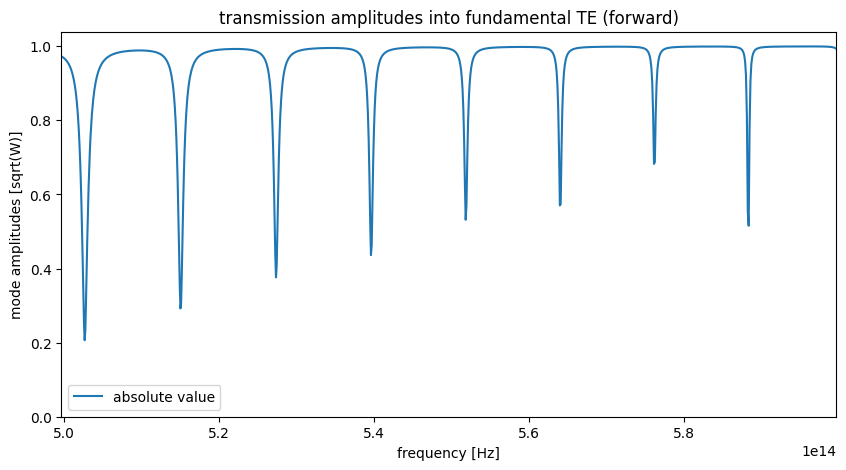

In [16]:
f, ax = plt.subplots(figsize=(10, 5))
transmission_amps.abs.plot.line(x="f", ax=ax, label="absolute value")
# transmission_amps.real.abs.plot.line(x='f', ax=ax, label='|real|')
ax.legend()
ax.set_title("transmission amplitudes into fundamental TE (forward)")
ax.set_ylim(0, None)
ax.set_xlim(freqs_measure[0], freqs_measure[-1])
plt.show()
